# How bad is the 4th wave going to be?

We explore two scenarios for the next month:

- Option 1: The R-value stays at 1.25 (as it has been for a few days now) - this is exponential growth

1. We see a linear increase in the *daily* new infections for the past week: we assume this trend continues - this is quadratic growth in the total number of infections

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import oscovida as ov
%config InlineBackend.figure_formats = ['svg']
# ov.clear_cache()

In [83]:
cases_jh, deaths_jh = ov.get_country_data("Germany")

In [89]:
# compute weekly mean (average over the last 7 days)
c = cases_jh.rolling(window=7, center=False).mean()

Text(0, 0.5, 'new daily cases')

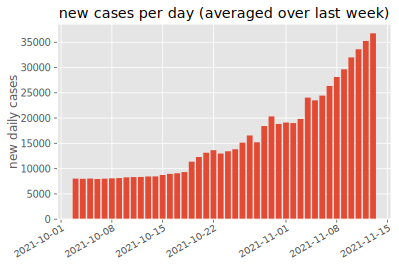

In [96]:
# infections per day (averaged over 7 days)
# basically proportional to the incidence
daily_cases = c.diff()[-42:]

fig, ax = plt.subplots()
ax.bar(daily_cases.index, daily_cases)
fig.autofmt_xdate()
ax.set_title("new cases per day (averaged over last week)")
ax.set_ylabel("new daily cases")

In [103]:
f"Last data point is from {daily_cases.index[-1].date()}."

'Last data point is from 2021-11-13.'

## Estimate growth rate of new daily infections by using linear fit for individual weeks

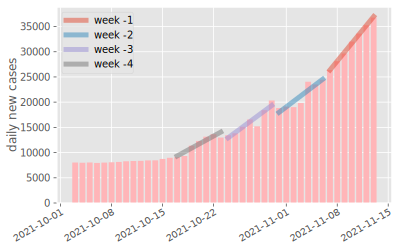

In [125]:
fig, ax = plt.subplots()
ax.bar(daily_cases.index, daily_cases, color='C6', alpha=1)
fit_coef = {}
fit_func = {}
nweeks = 4
for i in range(nweeks):
    # indices for days to look at one week at a time
    start = -7*(i+1)
    stop = -7*i
    if stop == 0: stop = None
    # convert dates to number of days for fitting routine
    X = mdates.date2num(daily_cases.index[start:stop]) 
    Y = daily_cases[start:stop] 
    # fit affine linear function to one week of data points
    ps = np.polyfit(X, Y, 1)
    m, a = ps             # extract slope m and offset a        
    fit_coef[i] = (m, a)  # to display later
    fit = np.poly1d(ps)
    fit_func[i] = fit   # re-use later in the notebook

    ax.plot(Y.index, fit(X), linewidth=5, alpha=0.5, label=f'week -{i+1}')

fig.autofmt_xdate()
ax.legend()
ax.set_ylabel("daily new cases");


In [118]:
fit_coef

{0: (1766.4693877537343, -33427013.714259814),
 1: (1095.1836734680578, -20714946.816301342),
 2: (1069.4030612242636, -20224457.71938348),
 3: (790.515306122628, -14944854.306125835)}

In [119]:
def daily_growth_to_incidence(g, country='Germany'):
    """Given a time series g of new infections per day, 
    return the corresponding incidence (for country)"""
    pop = ov.population(country)
    
    # 7 days * g new cases
    new_cases = 7 * g
    # divide by population and multiply with 100k
    return new_cases / pop * 1e5

assert abs(daily_growth_to_incidence(33000) - 278) < 1

# Assume number of *daily new infections* stays constant

Based on the last week, we have new infections per day:

In [129]:
# compute daily new cases and incidence for the next 4 weeks
nc1 = []   # new cases
model1 = fit_func[0]
daysrange = range(1, 30, 7)
for days in daysrange:
    day = mdates.date2num(daily_cases.index[-1]) + days 
    increase = model1(day)
    nc1.append(increase)
    incidence = daily_growth_to_incidence(increase)
    print(f"{days:2} : {round(model1(day)):5} : {round(incidence)}")

 1 : 38749 : 326
 8 : 51114 : 430
15 : 63479 : 534
22 : 75845 : 638
29 : 88210 : 743


In [141]:
# create data frame for convencience
nc1 = []   # new cases
model1 = fit_func[0]
futuredays = np.arange(1, 30, dtype='int') + mdates.date2num(daily_cases.index[-1])
new_cases = model1(futuredays)
incidence = daily_growth_to_incidence(new_cases)
index = pd.to_datetime(mdates.num2date(futuredays)).date
x = pd.DataFrame(index=index, data={'new cases' : new_cases,
                                        'incidence' : incidence})
x.head()
x.tail()

,new cases,incidence
2021-12-08,81144.102041,683.071977
2021-12-09,82910.571429,697.942137
2021-12-10,84677.040816,712.812296
2021-12-11,86443.510204,727.682455
2021-12-12,88209.979592,742.552615


In [122]:
for days in range(1, 30, 7):
    day = mdates.date2num(daily_cases.index[-1]) + days
    increase = model1(day)
    incidence = daily_growth_to_incidence(increase)
    print(f"{days} : {round(model1(day))} : {round(incidence)}")

1 : 38749 : 326
8 : 51114 : 430
15 : 63479 : 534
22 : 75845 : 638
29 : 88210 : 743


## Plot bars for different models

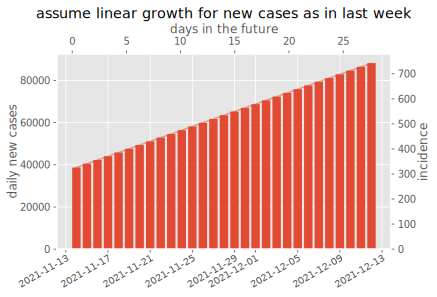

In [177]:
def plot_predictions(series :pd.Series, title):
    """Expect series to be series with daily 
    new cases and date as index."""
    assert isinstance(series, pd.Series)
    
    fig, ax = plt.subplots()
    incidence = daily_growth_to_incidence(series)
    
    ax.bar(series.index, series)
    fig.autofmt_xdate()
    
    # hacks to show two y-scales
    ax2 = ax.twinx()
    ax2.plot(series.index, incidence, alpha=0.5)
    ax2.set_ylim(bottom=0)
    ax.set_ylim(top=series.max()*1.05)
    ax2.set_ylim(top=incidence.max()*1.05)
    ax2.grid(False)
    
    # hacks for show second x-axis at the top
    ax3 = ax.twiny()
    ax3.grid(False)
    ax3.plot(mdates.date2num(series.index - series.index[0]), alpha=0)

    # labels
    ax.set_ylabel('daily new cases')
    ax2.set_ylabel('incidence')
    ax3.set_xlabel('days in the future')
    
    ax.set_title(title)
    
    
plot_predictions(x['new cases'], "assume linear growth for new cases as in last week")

# Assuming exponential growth with constant R

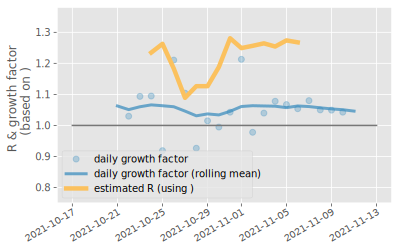

In [178]:
fig, ax = plt.subplots()
ov.plot_reproduction_number(ax=ax, series=cases_jh[-28:])
fig.autofmt_xdate()

This is an R value of approximately 1.25. To extract this number from the reported infections per day, we have assumed reproduction interval of 4 days: i.e. every 4 days each currently infected person will infect 1.25 people. (See https://oscovida.github.io/r-value.html for more details.)

Current infection numbers per day (based on data averaged over the last week) are

In [13]:
daily_cases[-1:]

2021-11-13    36766.285714
Freq: D, Name: Germany cases, dtype: float64

If the current exponential growth does not change, we expect the following number of daily infections for the next 4 weeks:


In [181]:
r = 1.25
int = 4  # serial interval (time re-infect next generation)
n0 = float(daily_cases[-1])
days = np.linspace(1, 28, 28)
new_cases = n0*r**(days/4)
index = days.astype('timedelta64[D]') + daily_cases.index[-1]
exp_growth = pd.DataFrame(index=index, data={'new cases': new_cases, 
                                             'days' : days})


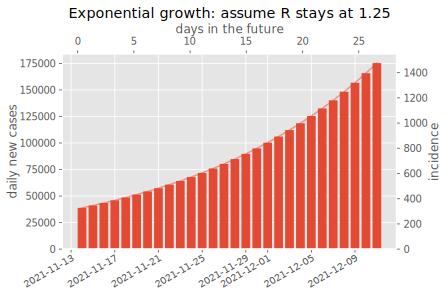

In [183]:
plot_predictions(exp_growth['new cases'], "Exponential growth: assume R stays at 1.25")